In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma

In [2]:
## funções auxiliares
def dB(x):
    "Converte escalar para dB"
    return 10 * np.log10(x)


def dBm(x):
    "Converte escalar para dB"
    return 10 * np.log10(x / 0.001)


def escalar(x):
    "Converte dB para escalar"
    return 10 ** (x / 10)


def tratar_dados(data_txt):
    data = pd.read_csv(
        data_txt,
        sep="|",
        header=None,
        encoding="utf-8",
        names=["data", "n", "id", "mensagem", "medida"],
    )
    data = data[pd.to_numeric(data["medida"], errors="coerce").notnull()]
    return np.array(data["medida"])

In [3]:
# Process only the data that hasn't been processed yet
dados_dict = {
    "dados_caos": "caos_1.txt",
    "dados_pet": "pet_eel.txt",
    "dados_predio": "predio_ctc.txt"
    "dados_perto_1": "sala_ctc_perto.txt",
    "dados_perto_2": "sala_ctc_perto_2.txt",
    "dados_escada_ctc_1": "escada_ctc_1.txt",
    "dados_sala_ctc": "sala_ctc.txt",
}

for var_name, file_name in dados_dict.items():
    if var_name not in globals():
        globals()[var_name] = tratar_dados(file_name)

SyntaxError: invalid syntax (1424183668.py, line 6)

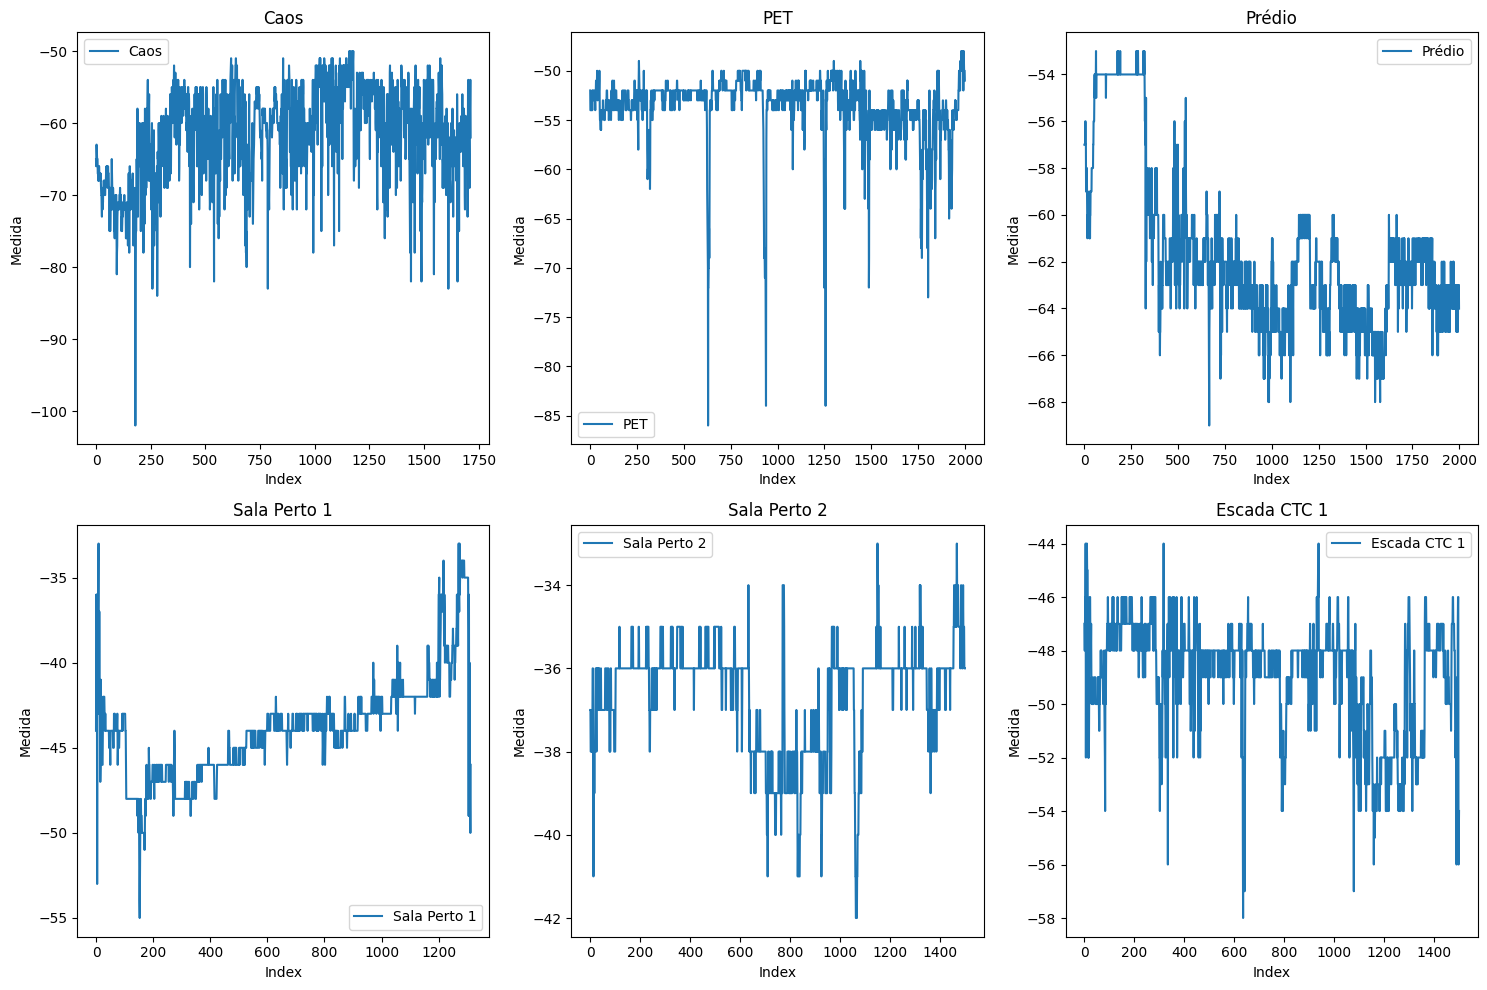

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].plot(dados_caos, label="Caos")
axes[0, 0].set_title("Caos")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Medida")
axes[0, 0].legend()

axes[0, 1].plot(dados_pet, label="PET")
axes[0, 1].set_title("PET")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Medida")
axes[0, 1].legend()

axes[0, 2].plot(dados_predio, label="Prédio")
axes[0, 2].set_title("Prédio")
axes[0, 2].set_xlabel("Index")
axes[0, 2].set_ylabel("Medida")
axes[0, 2].legend()

axes[1, 0].plot(dados_perto_1, label="Sala Perto 1")
axes[1, 0].set_title("Sala Perto 1")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Medida")
axes[1, 0].legend()

axes[1, 1].plot(dados_perto_2, label="Sala Perto 2")
axes[1, 1].set_title("Sala Perto 2")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Medida")
axes[1, 1].legend()

axes[1, 2].plot(dados_escada_ctc_1, label="Escada CTC 1")
axes[1, 2].set_title("Escada CTC 1")
axes[1, 2].set_xlabel("Index")
axes[1, 2].set_ylabel("Medida")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [4]:
def get_fading(PR):

    # Potência recebida [mW]
    PR = 10 ** (PR / 10)

    # Potência recebida média [mW]
    PRM = np.mean(PR)

    # Cálculo o Fading
    h = np.sqrt(PR / PRM)

    return h


def calculate_moments(h, k):
    return np.mean(h**k)


def get_nakagami_m(h):
    p = 100
    m = (
        calculate_moments(h, 1 / p)
        * calculate_moments(h, 2)
        / (
            2
            * p
            * (
                calculate_moments(h, 2 + 1 / p)
                - calculate_moments(h, 1 / p) * calculate_moments(h, 2)
            )
        )
    )

    return m


def nakagami_distribution(h, m):
    return (2 * (m**m) * (h ** (2 * m - 1)) * np.exp(-m * h * h)) / gamma(m)


def plot(m, h_data, title, bins=7, axis=plt):
    h = np.arange(0, 5, 0.0001)
    axis.hist(h_data, bins=bins, density=True, label="Medidas")
    axis.plot(h, nakagami_distribution(h, m), label="Nakagami m = " + str(round(m, 2)))
    axis.set_title(title)
    axis.legend()
    axis.grid()


def process_data(data, title, bins=10, axis=plt):
    h = get_fading(data)
    m = get_nakagami_m(h)
    plot(m, h, title, bins=bins, axis=axis)
    return m, h

In [5]:
# Calcular os momentos e o estimador m_p para cada conjunto de dados
h_caos = get_fading(dados_caos)
h_pet = get_fading(dados_pet)
h_predio = get_fading(dados_predio)


m_caos = get_nakagami_m(h_caos)
m_pet = get_nakagami_m(h_pet)
m_predio = get_nakagami_m(h_predio)


# Exibir os resultados
print(f"Estimador m no caos: {m_caos}")
print(f"Estimador m no PET: {m_pet}")
print(f"Estimador m no prédio: {m_predio}")

Estimador m no caos: 0.7659559033984378
Estimador m no PET: 3.529566233853285
Estimador m no prédio: 1.1373436804474044


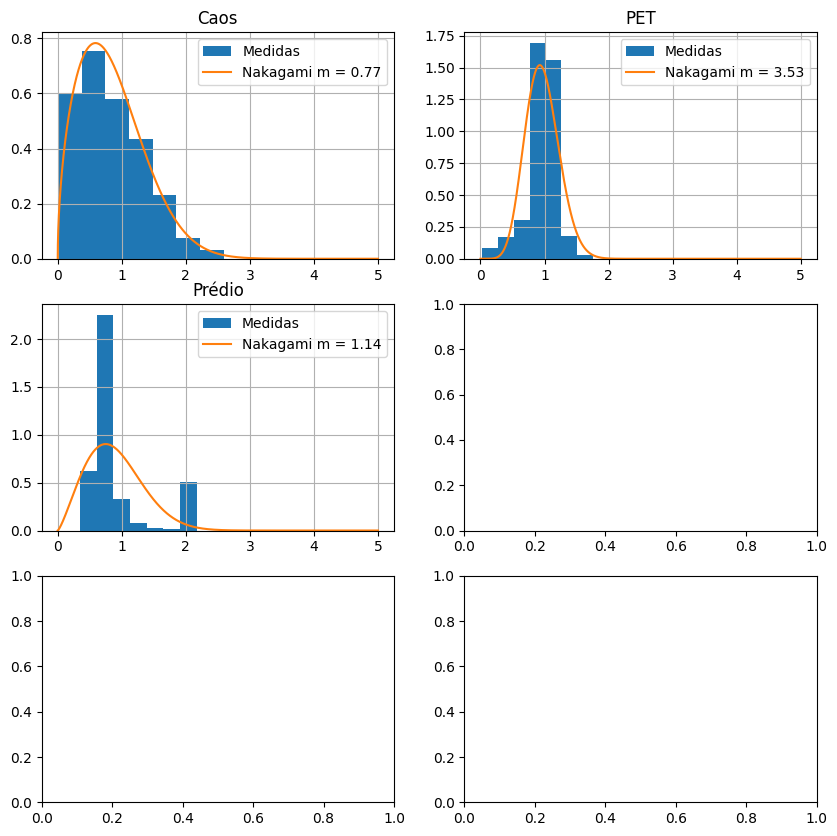

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

plot(m_caos, h_caos, "Caos", axis=axes[0, 0])
plot(m_pet, h_pet, "PET", axis=axes[0, 1])
plot(m_predio, h_predio, "Prédio", axis=axes[1, 0])

Estimated Nakagami m parameter: 0.7777059226221804
Location parameter: 0


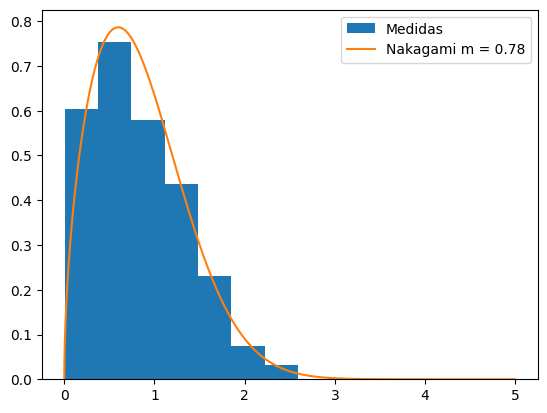

In [7]:
from scipy.stats import nakagami


def fit_nakagami_distribution(data):
    # Fit the data to the Nakagami distribution
    # Fix the location parameter to zero since Nakagami distribution is defined for x >= 0
    params = nakagami.fit(data, floc=0)

    # Extract the shape parameter m (Nakagami m parameter), location, and scale
    m, loc, scale = params
    h = np.arange(0, 5, 0.0001)

    print(f"Estimated Nakagami m parameter: {m}")
    print(f"Location parameter: {loc}")
    # print(f"Scale parameter: {scale}")
    plt.hist(data, bins=7, density=True, label="Medidas")
    plt.plot(h, nakagami_distribution(h, m), label="Nakagami m = " + str(round(m, 2)))
    plt.legend()
    plt.show()

    return m, loc, scale


# Example usage
m, loc, scale = fit_nakagami_distribution(h_caos)

m_escada = 5.567250543147377
m_sala = 7.764087582785201
m_sala_perto = 1.4783745392448178
m_sala_perto_2 = 12.995781366604293


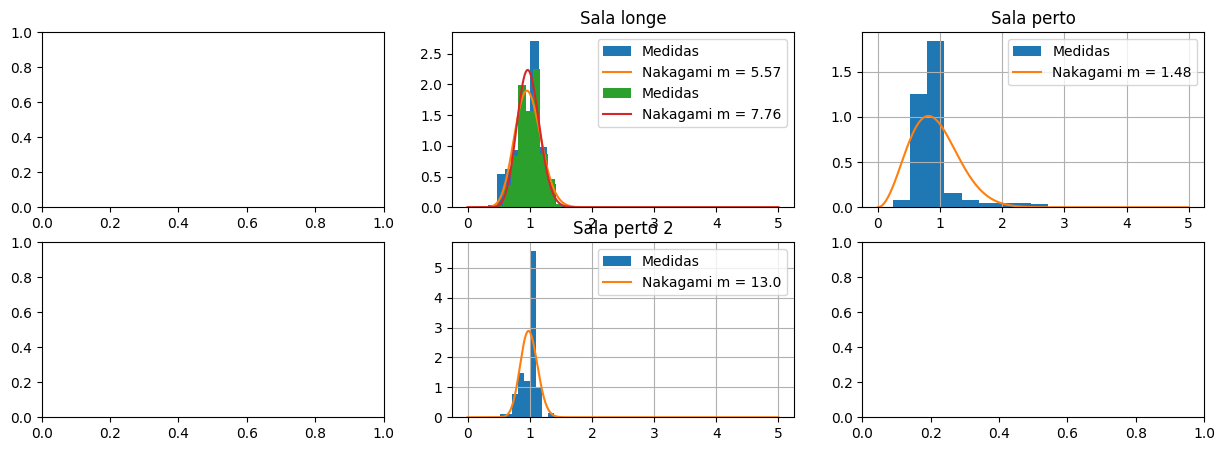

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))


dados_escada = tratar_dados("escada_ctc_1.txt")
m_escada, h_escada = process_data(dados_escada, "Escada", axis=axes[0, 1])
print(f"{m_escada = }")

dados_sala = tratar_dados("sala_ctc.txt")
m_sala, h_sala = process_data(dados_sala, "Sala longe", axis=axes[0, 1])
print(f"{m_sala = }")

dados_sala_perto = tratar_dados("sala_ctc_perto.txt")
m_sala_perto, h_sala_perto = process_data(
    dados_sala_perto, "Sala perto", axis=axes[0, 2]
)
print(f"{m_sala_perto = }")

dados_sala_perto_2 = tratar_dados("sala_ctc_perto_2.txt")
m_sala_perto_2, h_sala_perto_2 = process_data(
    dados_sala_perto_2, "Sala perto 2", axis=axes[1, 1]
)
print(f"{m_sala_perto_2 = }")